In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [2]:
# Defining some constants for data mining


NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TSLA'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

# Relative Strenght Index 'RSI', Moving Average Convergence Divergence 'MACD', Stochastic Oscillator %K 'STOCH'
# Accumulation-Distribution Line 'ADL', Average True Range 'ATR', Market Momentum 'MOM', Money Flow Index 'MFI'
# Rate-of-Change 'ROC', On Balance Volume 'OBV', Commodity Channel Index 'CCI', Ease of Movement 'EMV', 
# Vortex Indicator 'VORTEX'

[*********************100%***********************]  1 of 1 completed
             open   high    low  close  Adj Close    volume
Date                                                       
2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


<AxesSubplot:xlabel='Date'>

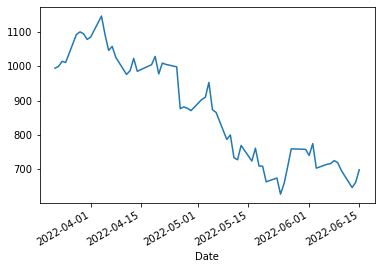

In [3]:
# Pull in historical data

start = (datetime.date.today() - datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

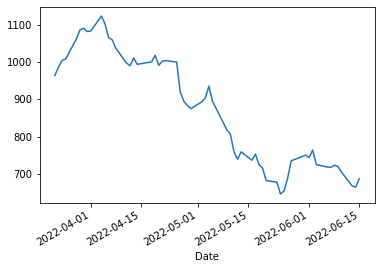

In [4]:
# Data cleaning, smoothing the dataset

def _exponential_smooth(data, alpha):
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [5]:
data.tail()

,open,high,low,close,Adj Close,volume
Date,,,,,,
2022-06-09,737.399586,758.089232,715.127824,720.363245,720.363245,2.992311e+07
2022-06-10,716.645336,732.356231,694.725732,704.975637,704.975637,3.160602e+07
2022-06-13,686.000868,698.259697,661.786498,667.427987,667.427987,3.332838e+07
2022-06-14,665.759294,685.734388,644.511789,664.335284,664.335284,3.289582e+07
2022-06-15,663.803253,699.550529,650.971634,686.867350,686.867350,3.720940e+07


In [6]:
# A function that uses the Finta API to calculate the technical indicators

def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Calculate moving averages
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove unused columns
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [7]:
live_pred_data = data.iloc[-5:]
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2022-06-09,720.363245,40.935702,-34.853181,-45.060482,59.750595,4.224214e+09,47.990121,66.269067,55.837710,6.359944,1.181802e+10,30.810848,1.838461,0.950887,0.994484,0.832841,0.897592,0.935994,0.993249,0.998894
2022-06-10,704.975637,38.483828,-33.988761,-42.846138,50.101009,4.209826e+09,45.452569,16.018188,56.993860,9.238456,1.178641e+10,-17.436338,3.507138,0.965460,1.030254,0.818018,0.883301,0.921159,0.976584,1.045477
2022-06-13,667.427987,33.250370,-35.919428,-41.460796,26.554835,4.186807e+09,44.763244,-67.466623,57.046904,2.038515,1.175308e+10,-92.836681,3.342169,0.957232,0.986410,0.777889,0.842526,0.879597,0.936342,1.083941
2022-06-14,664.335284,32.854056,-37.269431,-40.622523,24.615398,4.185550e+09,44.253688,-85.746836,56.735009,-3.573830,1.172019e+10,-103.250074,4.021424,0.944655,0.996647,0.777727,0.844819,0.882848,0.942686,1.057557
2022-06-15,686.867350,38.596342,-36.104974,-39.719013,30.669228,4.203330e+09,44.569218,-56.901889,57.456652,-6.535258,1.175740e+10,-61.485141,5.156276,0.923131,1.013192,0.807205,0.878525,0.918129,0.978793,1.158349


In [8]:
# Funtion to examine accuracy of prediction values.
# In a given row the funtion looks ahead to see if the price increased (1) or decreased (0)

def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-05-18,27.921762,-62.878565,-48.531257,8.802063,4.217115e+09,59.959923,-210.623001,35.541324,-18.851599,1.191972e+10,-113.823103,-22.103191,1.173422,0.828602,0.789751,0.812640,0.835110,0.916720,0.953150,0.0
2022-05-19,27.053107,-64.789844,-51.782974,6.167789,4.207597e+09,58.353263,-180.227081,27.713334,-20.895998,1.189005e+10,-110.779718,-25.686630,1.215034,0.791631,0.782211,0.808691,0.833353,0.918725,0.982864,0.0
2022-05-20,24.360823,-68.189394,-55.064258,8.797547,4.194797e+09,59.195400,-194.216978,27.364444,-27.125881,1.184826e+10,-123.125101,-27.494845,1.212434,0.752769,0.749725,0.779348,0.805789,0.894645,1.301171,0.0
2022-05-23,24.015955,-70.429561,-58.137319,10.930595,4.203016e+09,59.787756,-140.912417,20.984414,-24.329593,1.181437e+10,-123.988585,-31.968852,1.256569,0.713156,0.748592,0.782305,0.811336,0.905605,1.045492,0.0
2022-05-24,21.640415,-73.929445,-61.295744,5.199560,4.197333e+09,58.867903,-161.041349,14.094316,-26.324318,1.178320e+10,-130.578409,-36.404567,1.312401,0.672607,0.717330,0.754147,0.784957,0.883084,0.967634,1.0


In [9]:
# Function to split the data into training and test sets

def _split_data(data):

    y = data['pred']
    features = [x for x in data.columns if x not in ['pred']]
    X = data[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 4 * len(X) // 5)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = _split_data(data)
print('X Train : ' + str(len(X_train)))
print('X Test  : ' + str(len(X_test)))
print('y Train : ' + str(len(y_train)))
print('y Test  : ' + str(len(y_test)))

X Train : 2387
X Test  : 597
y Train : 2387
y Test  : 597


In [10]:
# Random Forest Classifier to train the model

def _train_random_forest(X_train, y_train, X_test, y_test):
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

{'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       255
         1.0       0.89      0.92      0.91       342

    accuracy                           0.89       597
   macro avg       0.89      0.89      0.89       597
weighted avg       0.89      0.89      0.89       597

[[216  39]
 [ 26 316]]


In [11]:
# K-Neighbors Classifier to train the model

def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
        
knn_model = _train_KNN(X_train, y_train, X_test, y_test)

{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74       255
         1.0       0.80      0.82      0.81       342

    accuracy                           0.78       597
   macro avg       0.78      0.78      0.78       597
weighted avg       0.78      0.78      0.78       597

[[185  70]
 [ 60 282]]


In [12]:
# Gradient Boosting Classifier to train the model

def _train_GBT(X_train, y_train, X_test, y_test):
    
    clf = GradientBoostingClassifier()
    
    # Dictionary of parameters to optimize
    params_gbt = {'n_estimators' :[150,160,170,180] , 'learning_rate' :[0.2,0.1,0.09] }
    
    # Use gridsearch to test all values for n_neighbors
    grid_search = GridSearchCV(clf, params_gbt, cv=5)
    
    # Fit model to training data
    grid_search.fit(X_train, y_train)
    
    gbt_best = grid_search.best_estimator_
    
    # Save best model
    print(grid_search.best_params_)
    
    prediction = gbt_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
        
    return gbt_best

gbt_model = _train_GBT(X_train, y_train, X_test, y_test)

{'learning_rate': 0.2, 'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       255
         1.0       0.83      0.87      0.85       342

    accuracy                           0.83       597
   macro avg       0.82      0.82      0.82       597
weighted avg       0.83      0.83      0.82       597

[[195  60]
 [ 44 298]]


In [13]:
# Combinging the models for better accuracy

def _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model), ('gbt', gbt_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)

0.8626465661641541
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83       255
         1.0       0.86      0.90      0.88       342

    accuracy                           0.86       597
   macro avg       0.86      0.86      0.86       597
weighted avg       0.86      0.86      0.86       597

[[206  49]
 [ 33 309]]


In [14]:
# Cross Validation to produce sampling and confirm accuracy

def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    
    # Create a tuple list of our models
    estimators=[('knn', knn), ('rf', rf)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
                
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)
        
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
#        print('rf prediction is ', rf_prediction)
#        print('knn prediction is ', knn_prediction)
#        print('ensemble prediction is ', ensemble_prediction)
#        print('truth values are ', y_test.values)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
#        print(rf_accuracy, knn_accuracy, gbt_accuracy, ensemble_accuracy)

        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
cross_Validation(data)

RF Accuracy = 0.6152542372881352
KNN Accuracy = 0.6211864406779661
ENSEMBLE Accuracy = 0.6211864406779656


In [15]:
# Dataset to test the model and make a prediction

live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2022-06-09,720.363245,40.935702,-34.853181,-45.060482,59.750595,4.224214e+09,47.990121,66.269067,55.837710,6.359944,1.181802e+10,30.810848,1.838461,0.950887,0.994484,0.832841,0.897592,0.935994,0.993249,0.998894
2022-06-10,704.975637,38.483828,-33.988761,-42.846138,50.101009,4.209826e+09,45.452569,16.018188,56.993860,9.238456,1.178641e+10,-17.436338,3.507138,0.965460,1.030254,0.818018,0.883301,0.921159,0.976584,1.045477
2022-06-13,667.427987,33.250370,-35.919428,-41.460796,26.554835,4.186807e+09,44.763244,-67.466623,57.046904,2.038515,1.175308e+10,-92.836681,3.342169,0.957232,0.986410,0.777889,0.842526,0.879597,0.936342,1.083941
2022-06-14,664.335284,32.854056,-37.269431,-40.622523,24.615398,4.185550e+09,44.253688,-85.746836,56.735009,-3.573830,1.172019e+10,-103.250074,4.021424,0.944655,0.996647,0.777727,0.844819,0.882848,0.942686,1.057557
2022-06-15,686.867350,38.596342,-36.104974,-39.719013,30.669228,4.203330e+09,44.569218,-56.901889,57.456652,-6.535258,1.175740e+10,-61.485141,5.156276,0.923131,1.013192,0.807205,0.878525,0.918129,0.978793,1.158349


In [16]:
# Buy (1) Sell (0)
# Not financial advice, for educational/entertainment purposes only

del(live_pred_data['close'])
prediction = ensemble_model.predict(live_pred_data)
print(prediction)

[1. 1. 1. 1. 1.]
